In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sys
from pathlib import Path
import os
import xxhash
import random

from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import seaborn as sns

from bitarray import bitarray
from pympler import asizeof

from time import time

/Users/minsuhong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# [Desc.] :: Set Random Seed

np.random.seed(0)
random.seed(0)

In [3]:
# Target Application SNI
TARGET_SNI = {
    "youtube": ["googlevideo.com"],
    "youtube_tls": ["googlevideo.com"],
    "instagram": ["fbcdn.net"],
    "instagram_tls": ["fbcdn.net"],
    "netflix": ["nflxvideo.net"],
    "navertv": ["naver-vod.pstatic.net", "smartmediarep.com"],
    "soop": ["stream.sooplive.co.kr"],
    "steam": ["steambroadcast.akamaized.net"],
    "wavve": ["vod.cdn.wavve.com"],
    "coupangplay": ["cosmos.coupangstreaming.com"],
}

TARGET_COL = [
    'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'SPLT-Len', 'SPLT-Data', 'SNI', 'Rx-Bytes'
]

FIRST_PKT_N = 100
MIN_FLOW_LEN = 20
TOP_N_FLOWS = 20

N_FOLD = 5

DISC_RANGE = 13

In [4]:
# [Desc.] :: Class Structure of Bitmap Classifier

class BitmapClassifier:

    def __init__(self, dr, max_len, n_gram, n_classes):
        self.dr = dr
        self.max_len = max_len
        self.n_gram = n_gram
        self.n_classes = n_classes

        self.L = dr ** n_gram
        
        self.bitmap_total = [ bitarray(self.L) for _ in range(n_classes) ]
        self.bitmap_in = [ bitarray(self.L) for _ in range(n_classes) ]
        self.bitmap_out = [ bitarray(self.L) for _ in range(n_classes) ]

        return
    
    def train(self, X, y):
        total_scratcher, in_scratcher, out_scratcher = bitarray(self.L), bitarray(self.L), bitarray(self.L)
        for x_data, y_data in zip(X, y):
            self.bitmap_total[y_data] = self.bitmap_total[y_data] | x_data[0]
            self.bitmap_in[y_data] = self.bitmap_in[y_data] | x_data[1]
            self.bitmap_out[y_data] = self.bitmap_out[y_data] | x_data[2]

        return
    
    def test(self, X):
        y_pred = []
        max_score_arr = []
        cls_score_arr = []
        for x_data in X:
            max_class, max_score = -1, -1
            cls_scores = []
            for cls in range(self.n_classes):
                score = (x_data[0] & self.bitmap_total[cls]).count(1) + (x_data[1] & self.bitmap_in[cls]).count(1) + (x_data[2] & self.bitmap_out[cls]).count(1)
                cls_scores.append(score)
                if score > max_score:
                    max_score = score
                    max_class = cls
        
            y_pred += [max_class]
            max_score_arr.append(max_score)
            cls_score_arr.append(cls_scores)

        return y_pred, max_score_arr, cls_score_arr

    def clear(self):
        self.bitmap_total = [ bitarray(self.L) for _ in range(self.n_classes) ]
        self.bitmap_in = [ bitarray(self.L) for _ in range(self.n_classes) ]
        self.bitmap_out = [ bitarray(self.L) for _ in range(self.n_classes) ]

        return

    def bitarray_converting(self, data):
        res = bitarray(self.L)

        for d in [data[idx:idx+self.n_gram] for idx in range(0, min(len(data), self.max_len)-self.n_gram+1)]:
            res[sum([ (( self.dr ** idx ) if idx > 0 else 1) * val for idx, val in enumerate(reversed(d))])] = 1

        return res

    def data_factoring(self, df):
        label_dict = {}
        for idx, key in enumerate(sorted(df["Label"].unique())):
            label_dict[key] = idx
            
        X_total = df["Desc_freq"].apply( lambda x: self.bitarray_converting(x) )
        X_in = df["Desc_freq_In"].apply( lambda x: self.bitarray_converting(x) )
        X_out = df["Desc_freq_Out"].apply( lambda x: self.bitarray_converting(x) )
        
        return [ (a, b, c) for a, b, c in zip(X_total, X_in, X_out) ], df["Label"].apply(lambda x: label_dict[x]).to_numpy()
    

In [ ]:
# Load csv files
csv_folder = Path("../csv") # csv 폴더가 있는 경로
csv_files = list(csv_folder.glob("**/*.csv"))

In [6]:
def get_flow(csv, app_name):
    df = pd.read_csv(csv, usecols=TARGET_COL)
    sni_list = TARGET_SNI.get(app_name)
    if sni_list is None:
        raise ValueError(f"Invalid Application Name: {app_name}")
    try:
        df = df[df['SNI'].fillna('').astype(str).str.contains('|'.join(sni_list), na=False)]
    except AttributeError:
        raise ValueError(f"Invalid SNI Column: {df[~df['SNI'].apply(lambda x: isinstance(x, str))]}")
    df['Label'] = app_name
    df = df.sort_values(by=['Rx-Bytes'], axis=0, ascending=False)[:TOP_N_FLOWS]
    return df

In [ ]:
df_arr = []

for csv_file in csv_files:
    parts = csv_file.parts
    app_name, device, network, filename = parts[1:5]
    
    if app_name == "instagram_tls":
        app_name = "instagram"
    elif app_name.lower() == "bittorrent":
        continue
    elif app_name.lower() == "bittorrentutp":
        continue
    else:
        df_arr.append(get_flow(csv_file, app_name))

sys_df = pd.concat(df_arr, axis = 0).reset_index(drop=True)
sys_df["SPLT-Data"] = sys_df["SPLT-Data"].apply(
    lambda x : [int(tmp[1:-1]) for tmp in str(x)[1:-1].split(", ")]
)

In [8]:
sys_df["Label"].value_counts()

Label
netflix        1540
wavve           842
youtube_tls     437
navertv         313
instagram       272
soop            270
coupangplay     242
steam           132
youtube          96
Name: count, dtype: int64

In [9]:
# [Desc.] :: Builds Bytes Sequence

sys_df[f"First{FIRST_PKT_N}BytesArr"] = sys_df["SPLT-Data"].apply(lambda x : np.array([int(flow) for flow in x]))

In [10]:
# [Desc.] :: Builds Bytes Sequence

sys_df[f"First{FIRST_PKT_N}BytesArr_In"] = [x[x > 0][:FIRST_PKT_N] for x in sys_df[f"First{FIRST_PKT_N}BytesArr"]]
sys_df[f"First{FIRST_PKT_N}BytesArr_Out"] = [x[x < 0][:FIRST_PKT_N] for x in sys_df[f"First{FIRST_PKT_N}BytesArr"]]
sys_df[f"First{FIRST_PKT_N}BytesArr"] = [x[:FIRST_PKT_N] for x in sys_df[f"First{FIRST_PKT_N}BytesArr"]]

In [11]:
# [Desc.] :: Remove Flows under Specific Length

sys_df = sys_df[sys_df[f"First{FIRST_PKT_N}BytesArr"].apply(len) >= MIN_FLOW_LEN].reset_index(drop=True)

In [12]:
# [Desc.] :: Frequency Based Discretizing

def discretize_values(value, disc_range):
    if value == 0:
        return DISC_RANGE

    return int( (np.searchsorted(disc_range, value, side='right') - 1) + (1 if value > 0 else 0) )

In [13]:
# [Desc.] :: Get <Label name-index> dict.

label_dict = {}
for idx, key in enumerate(sorted(sys_df["Label"].unique())):
    label_dict[key] = idx

In [14]:
# [Desc.] :: Train & Test Bitmap Classifier

# Parameters
N_gram_res = []
best_res = {'score': 0}
N_GRAM = 4

for N_GRAM in range(2, 6):
    grid_res = []
    for VEC_LEN in range(5, 31, 5):
        tmp_arr = []
        
        X, y = sys_df[f"First{FIRST_PKT_N}BytesArr"].to_numpy(), sys_df[f"Label"].to_numpy()
        
        # N-Fold Cross Validation
        skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)
        
        max_score_arr = []
        
        # Train & Test
        merged_y_test = np.array([])
        merged_y_pred = np.array([])
        merged_cls_score_arr = []
        bitmap_record = []
        disc_record = []
        
        sys_test_idx_arr = np.array([])
        
        pre, rec, f1, acc, test_time = 0, 0, 0, 0, 0
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):

            # Merging test data of all folds
            sys_test_idx_arr = np.hstack([sys_test_idx_arr, test_index])

            # Get Train & Test data of current fold
            X_train = sys_df.iloc[train_index].reset_index(drop=True)
            X_test = sys_df.iloc[test_index].reset_index(drop=True)

            # Frequency-based Discretizing
            tmp = np.hstack(X_train[f"First{FIRST_PKT_N}BytesArr"])
            neg_l, neg_disc_range = pd.qcut(tmp[tmp < 0], q=DISC_RANGE-1, retbins=True, labels=False, duplicates='drop')
            pos_l, pos_disc_range = pd.qcut(tmp[tmp > 0], q=DISC_RANGE-1, retbins=True, labels=False, duplicates='drop')
            disc_range = np.hstack([[-np.inf], neg_disc_range, [0], pos_disc_range, [np.inf]])
            disc_record.append(disc_range)

            # Discretizing train & test data
            X_train["Desc_freq"] = X_train[f"First{FIRST_PKT_N}BytesArr"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])
            X_train["Desc_freq_In"] = X_train[f"First{FIRST_PKT_N}BytesArr_In"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])
            X_train["Desc_freq_Out"] = X_train[f"First{FIRST_PKT_N}BytesArr_Out"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])

            X_test["Desc_freq"] = X_test[f"First{FIRST_PKT_N}BytesArr"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])
            X_test["Desc_freq_In"] = X_test[f"First{FIRST_PKT_N}BytesArr_In"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])
            X_test["Desc_freq_Out"] = X_test[f"First{FIRST_PKT_N}BytesArr_Out"].apply(lambda seq: [discretize_values(tmp, disc_range) for tmp in seq])

            # Call Classifier class
            bitmap_classifier = BitmapClassifier(len(disc_range), VEC_LEN, N_GRAM, len(label_dict.keys()))

            # Data factoring
            X_train, y_train = bitmap_classifier.data_factoring(X_train)
            X_test, y_test = bitmap_classifier.data_factoring(X_test)

            # Bitmap insertion (Encoding)
            bitmap_classifier.clear()
            bitmap_classifier.train(X_train, y_train)
            bitmap_record.append((bitmap_classifier.bitmap_total, bitmap_classifier.bitmap_in, bitmap_classifier.bitmap_out))
            
            # Test (Decoding)
            start = time()
            y_pred, tmp_max_score_arr, cls_score_arr = bitmap_classifier.test(X_test)
            test_time += (time() - start) / len(X_test)

            # Merging Predict result
            max_score_arr += tmp_max_score_arr
            merged_y_test = np.hstack([merged_y_test, y_test])
            merged_y_pred = np.hstack([merged_y_pred, y_pred])
            merged_cls_score_arr += cls_score_arr
        
            
            # Sum. Scores
            pre += precision_score(y_test, y_pred, average='macro')
            rec += recall_score(y_test, y_pred, average='macro')
            f1 += f1_score(y_test, y_pred, average='macro') 
            acc += accuracy_score(y_test, y_pred) 
        
        # Print Averaged Score.
        print(f1_score(merged_y_test, merged_y_pred, average='macro') )
        print(round(asizeof.asizeof(bitmap_classifier) / 2**20, 4), "MB", end=" ")
        print(f"[VEC_LEN ={VEC_LEN:>3}, N_GRAM ={N_GRAM:>2}] Precision :: {pre / N_FOLD:.4f} | Recall :: {rec / N_FOLD:.4f} | F1 :: {f1 / N_FOLD:.4f} || acc. :: {acc / N_FOLD:.4f}    | {test_time / N_FOLD / len(X_test):.8f} Sec/Data")

        tmp_arr.append( (pre / N_FOLD, rec / N_FOLD, f1 / N_FOLD) )

        # Recording Best output Data
        if f1/N_FOLD > best_res['score']:
            best_res['VEC_LEN'] = VEC_LEN
            best_res['N_GRAM'] = N_GRAM
            best_res['y_pred'] = merged_y_pred
            best_res['y_test'] = merged_y_test
            best_res['score'] = f1/N_FOLD
            best_res['bitmap'] = bitmap_record[-1]
            best_res['score_arr'] = max_score_arr
            best_res['cls_score_arr'] = merged_cls_score_arr
            best_res['disc'] = disc_record[-1]
            best_res['class'] = [key for key in label_dict.keys()]

        grid_res.append(tmp_arr)
        print()
    N_gram_res.append(grid_res)
    print("=====================================")

0.7585441906070388
0.0051 MB [VEC_LEN =  5, N_GRAM = 2] Precision :: 0.8545 | Recall :: 0.7703 | F1 :: 0.7571 || acc. :: 0.8638    | 0.00000000 Sec/Data

0.8490545417500918
0.005 MB [VEC_LEN = 10, N_GRAM = 2] Precision :: 0.9052 | Recall :: 0.8436 | F1 :: 0.8480 || acc. :: 0.9196    | 0.00000000 Sec/Data

0.8854191539211711
0.005 MB [VEC_LEN = 15, N_GRAM = 2] Precision :: 0.9300 | Recall :: 0.8739 | F1 :: 0.8846 || acc. :: 0.9390    | 0.00000000 Sec/Data

0.854478605932874
0.005 MB [VEC_LEN = 20, N_GRAM = 2] Precision :: 0.9123 | Recall :: 0.8361 | F1 :: 0.8511 || acc. :: 0.9253    | 0.00000001 Sec/Data

0.8102916699539874
0.005 MB [VEC_LEN = 25, N_GRAM = 2] Precision :: 0.8838 | Recall :: 0.7900 | F1 :: 0.8063 || acc. :: 0.9064    | 0.00000000 Sec/Data

0.7623932669387428
0.005 MB [VEC_LEN = 30, N_GRAM = 2] Precision :: 0.8849 | Recall :: 0.7480 | F1 :: 0.7586 || acc. :: 0.8767    | 0.00000000 Sec/Data

0.9117017903900295
0.0377 MB [VEC_LEN =  5, N_GRAM = 3] Precision :: 0.9430 | Reca

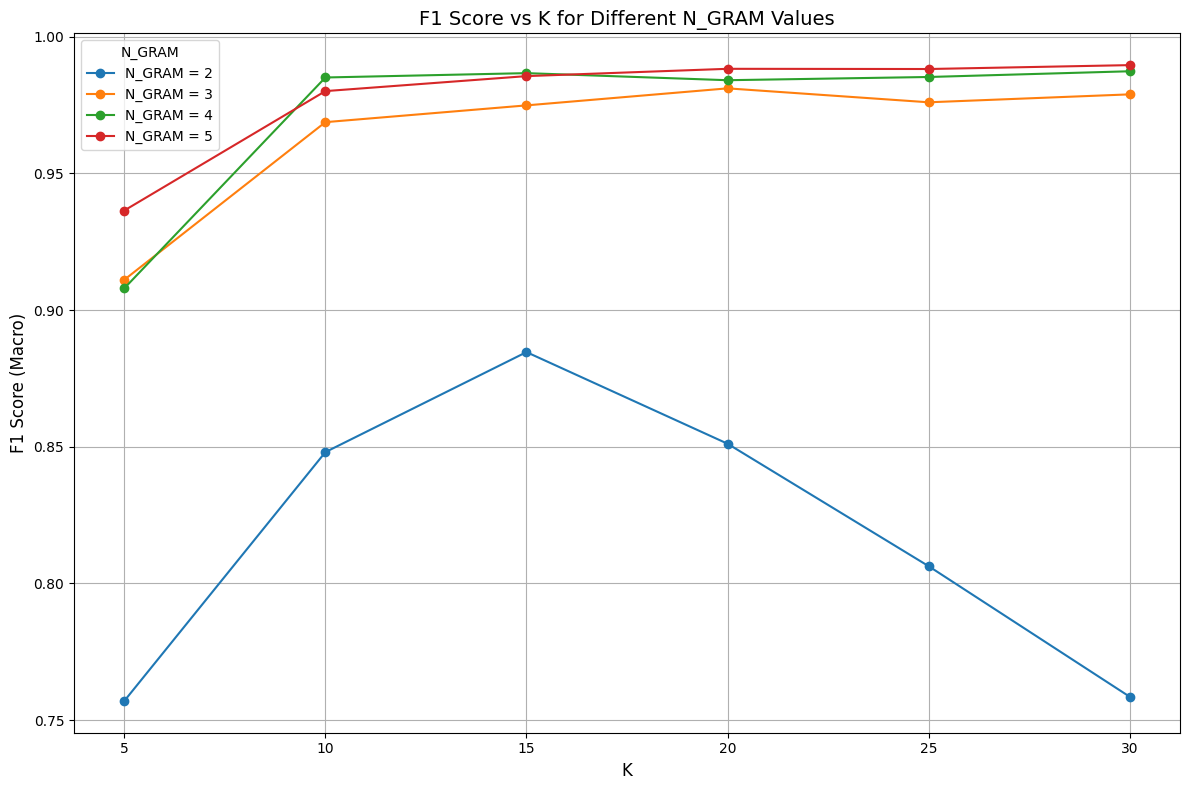

In [20]:
import matplotlib.pyplot as plt

vec_len_values = list(range(5, 31, 5))
n_gram_values = list(range(2, 6))  # 2, 3, 4, 5

plt.figure(figsize=(12, 8))

# 각 N_GRAM 값에 대해 선 그래프 추가
for n_idx, N_GRAM in enumerate(n_gram_values):
    f1_scores = [N_gram_res[n_idx][v_idx][0][2] for v_idx in range(len(vec_len_values))]
    plt.plot(vec_len_values, f1_scores, marker='o', label=f'N_GRAM = {N_GRAM}')

# 그래프 설정
plt.title('F1 Score vs K for Different N_GRAM Values', fontsize=14)
plt.xlabel('K', fontsize=12)
plt.ylabel('F1 Score (Macro)', fontsize=12)
plt.xticks(vec_len_values)
plt.grid(True)
plt.legend(title='N_GRAM')
plt.tight_layout()
plt.show()

In [16]:
best_res['VEC_LEN']

30

In [17]:
best_res['disc']

array([      -inf, -1.460e+03, -1.448e+03, -1.400e+03, -1.141e+03,
       -9.900e+02, -6.810e+02, -5.170e+02, -3.480e+02, -1.350e+02,
       -6.400e+01, -3.400e+01, -1.000e+00,  0.000e+00,  1.000e+00,
        4.190e+02,  1.250e+03,  1.400e+03,  1.448e+03,  1.460e+03,
        1.600e+03,        inf])

In [18]:
import pickle
from datetime import datetime

now = datetime.now().strftime("%m%d_%H%M")

# 저장
with open(f"pkl/bitmap_{now}.pkl", "wb") as f:
    pickle.dump(best_res, f)

In [19]:
y_2_label = dict([b, a] for (a, b) in label_dict.items())

fail_arr = np.where(best_res['y_test'] != best_res['y_pred'])[0]

ctgr = f"| {'Answer':^20} | {'Predict':^20} | " + ' '.join( [ f"{'['+str(a)+']'}" for a in range(10)] ) + " |"

print(ctgr)
print("|" + "=" * (len(ctgr)-2) + "|")
for idx in fail_arr:
    print(
        f"| {'['+str(int(best_res['y_test'][idx]))+'] '+y_2_label[int(best_res['y_test'][idx])]:<20} | {'['+str(int(best_res['y_pred'][idx]))+'] '+y_2_label[int(best_res['y_pred'][idx])]:<20} | {' '.join([f'{tmp:>3}' for tmp in best_res['cls_score_arr'][idx]])}" + " |"
    )


print("|" + "=" * (len(ctgr)-2) + "|")

|        Answer        |       Predict        | [0] [1] [2] [3] [4] [5] [6] [7] [8] [9] |
|=======================================================================================|
| [4] soop             | [0] coupangplay      |  36   9  14   4  35  15   5   5  19 |
| [0] coupangplay      | [2] navertv          |  39  11  43  18  21  22  14   4   7 |
| [2] navertv          | [3] netflix          |   8   5   9  13  13   6  13   0   5 |
| [7] youtube          | [1] instagram        |   4   9   2   0   4   0   0   9   0 |
| [5] steam            | [0] coupangplay      |  26  13  10   8  19  21   9   1  12 |
| [5] steam            | [8] youtube_tls      |  21   0   3   0   8  23   0   1  25 |
| [1] instagram        | [0] coupangplay      |   8   7   5   5   4   8   5   0   7 |
| [7] youtube          | [0] coupangplay      |  24   0   2   1  13   5   4   0  24 |
| [5] steam            | [0] coupangplay      |  28   5  22  20  18  24  21   0   9 |
| [6] wavve            | [3] netflix          